# Airline Passenger Satisfaction Data Analysis and ML Prediction

## Problem Statement

### Significance :

In today's competitive airline industry, accurately predicting and addressing the factors that impact passenger satisfaction is fundamental for airlines to safeguard against revenue loss and maintain a competitive edge in the market. By leveraging data analysis and machine learning techniques, airlines can proactively predict satisfaction levels, enhance passenger experiences, optimize operational efficiency, and ultimately gain competitive advantages. Improved passenger satisfaction not only fosters loyalty but also boosts revenue through repeat business and positive recommendations. This strategy ensures a mutually beneficial outcome for all stakeholders involved, including airlines, passengers, resellers, and regulatory bodies, creating a positive scenario for everyone.

### Dataset Description :
The dataset contains 5000 rows with information on airline passenger feedback, including ratings, comments, flight details, and demographic information, collected to analyze satisfaction levels and predict future passenger preferences using machine learning techniques.

### Attribute Information
1) **id** 	: Customer unique ID
2) **Gender** : Gender of the passengers (Female, Male) <br>
3) **Customer Type** : The customer type (Loyal customer, disloyal customer)<br>
4) **Age** : The actual age of the passengers<br>
5) **Type of Travel** : Purpose of the flight of the passengers (Personal Travel, Business Travel)<br>
6) **Class** : Travel class in the plane of the passengers (Business, Eco, Eco Plus)<br>
7) **Flight distance** : The flight distance of this journey<br>
8) **Inflight wifi service** : Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)<br>
9) **Departure/Arrival time convenient** : Satisfaction level of Departure/Arrival time convenient<br>
10) **Ease of Online booking** : Satisfaction level of online booking<br>
11) **Gate location** : Satisfaction level of Gate location<br>
12) **Food and drink** : Satisfaction level of Food and drink<br>
13) **Online boarding** : Satisfaction level of online boarding<br>
14) **Seat comfort** : Satisfaction level of Seat comfort<br>
15) **Inflight entertainment** : Satisfaction level of inflight entertainment<br>
16) **On-board service** : Satisfaction level of On-board service<br>
17) **Leg room service** : Satisfaction level of Leg room service<br>
18) **Baggage handling** : Satisfaction level of baggage handling<br>
19) **Check-in service** : Satisfaction level of Check-in service<br>
20) **Inflight service** : Satisfaction level of inflight service<br>
21) **Cleanliness** : Satisfaction level of Cleanliness<br>
22) **Departure Delay in Minutes** : Minutes delayed when departure<br>
23) **Arrival Delay in Minutes** : Minutes delayed when Arrival<br>
24) **Satisfaction** : Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

### Dataset Source :
https://www.kaggle.com/datasets/johndddddd/customer-satisfaction

### Importing neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,RandomizedSearchCV
import warnings  
warnings.filterwarnings('ignore')
from sqlite3 import Error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Methodology 
### Normalization:
- Transforming raw data into normalized tables, PASSENGER, Travel_Info, Inflight_Experience, Service_Quality, Flight_Delays, Overall_Satisfaction.

### Loading into Pandas:
- Combine the above 6 tables to get the original data
- Load this data into Pandas DataFrames for analysis.

### Exploratory Data Analysis (EDA):
- Statistically summarize data and create visualizations to understand patterns and relationships.

### Machine Learning (ML) Modeling:
- Preparing data, selecting ML models (e.g., RandomForest), and train them analyze satisfaction levels and predict future passenger preferences.

### Model Evaluation:
- Assess model performance using metrics like accuracy and confusion matrix.

# Normalization 

### Steps to Normalizing the database. 

- **create_connection** : returns the connection object to the database
- **create_table** : creates a table based on the input sql query
- **execute_sql_statement** : executes a given sql statement on the given connection

In [2]:

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print("test")
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

### Creating Tables
- Creating PASSENGER, Travel_Info, Inflight_Experience, Service_Quality, Flight_Delays, Overall_Satisfaction tables

### Inserting Data into the tables
- Making use of *INSERT INTO* SQL Query to insert values into the tables
- Here we are using *executemany* method from the cursor object to insert multiple rows at a time into the database

In [3]:
data_filename = "MP Final1.csv"
normalized_database_filename = "Major_Project_Normalised.db"
'''
with open(data_filename) as file:
    header = next(file)
    Values = set()
    print(header)
    for line in file:
        data = line.strip().split(',')
        Gender = data[2]
        Customer_Type = data[3]
        Values.add((Gender,Customer_Type))  
'''
def create_passenger_detail_table(data_filename, normalized_database_filename):
    con_norm = create_connection(normalized_database_filename,delete_db=True)
    curr = con_norm.cursor()
    create_passenger_detail_table_querry = """
    CREATE TABLE PASSENGER(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        CustomerID INTEGER NOT NULL,
        Gender TEXT,
        CustomerType TEXT,
        Age INTEGER
    )"""
    create_table(con_norm, create_passenger_detail_table_querry, drop_table_name= "PASSENGER")
    def insert_passenger_details(con_norm, values):
        sql = '''INSERT INTO PASSENGER (CustomerID, Gender, CustomerType, Age) VALUES (?,?,?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[1],data[2],data[3],data[4]))
        insert_passenger_details(con_norm,values)
create_passenger_detail_table(data_filename, normalized_database_filename)

In [4]:
con_norm = create_connection(normalized_database_filename)
curr = con_norm.cursor()
## TRAVEL_INFO TABLE
def create_travel_info_table(data_filename, normalized_database_filename):
    create_travel_info_table_querry = """
    CREATE TABLE Travel_Info(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        Type_of_Travel TEXT,
        Class TEXT,
        Flight_Distance INTEGER,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_travel_info_table_querry, drop_table_name= "Travel_Info")
    def insert_travel_info_details(con_norm, values):
        sql = '''INSERT INTO Travel_Info (Type_of_Travel, Class, Flight_Distance) VALUES (?,?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[5],data[6],data[7]))
        insert_travel_info_details(con_norm,values)
## Booking_Info TABLE
def create_Booking_Info_table(data_filename, normalized_database_filename):
    create_Booking_Info_table_querry = """
    CREATE TABLE Booking_Info(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        Departure_Arrival_time_convenient INTEGER,
        Ease_of_Online_booking INTEGER,
        Gate_location INTEGER,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_Booking_Info_table_querry, drop_table_name= "Booking_Info")
    def insert_Booking_Info_details(con_norm, values):
        sql = '''INSERT INTO Booking_Info (Departure_Arrival_time_convenient, Ease_of_Online_booking, Gate_location) VALUES (?,?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[9],data[10],data[11]))
        insert_Booking_Info_details(con_norm,values)
#create_Booking_Info_table(data_filename, normalized_database_filename)
# Inflight_Experience Table
def create_Inflight_Experience_table(data_filename, normalized_database_filename):
    create_Inflight_Experience_table_querry = """
    CREATE TABLE Inflight_Experience(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        Inflight_wifi_service INTEGER,
        Food_and_drink INTEGER,
        Online_boarding INTEGER,
        Seat_comfort INTEGER,
        Inflight_entertainment INTEGER,
        On_board_service INTEGER,
        Leg_room_service INTEGER,
        Cleanliness INTEGER,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_Inflight_Experience_table_querry, drop_table_name= "Inflight_Experience")
    def insert_Inflight_Experience_details(con_norm, values):
        sql = '''INSERT INTO Inflight_Experience (Inflight_wifi_service, Food_and_drink, Online_boarding, Seat_comfort, Inflight_entertainment, On_board_service, Leg_room_service, Cleanliness) VALUES (?,?,?,?,?,?,?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[8],data[12],data[13],data[14],data[15],data[16],data[17],data[21]))
        insert_Inflight_Experience_details(con_norm,values)
#create_Inflight_Experience_table(data_filename, normalized_database_filename)
#Service_Quality
def create_Service_Quality_table(data_filename, normalized_database_filename):
    create_Service_Quality_table_querry = """
    CREATE TABLE Service_Quality(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        Baggage_handling INTEGER,
        Checkin_service INTEGER,
        Inflight_service INTEGER,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_Service_Quality_table_querry, drop_table_name= "Service_Quality")
    def insert_Service_Quality_details(con_norm, values):
        sql = '''INSERT INTO Service_Quality (Baggage_handling, Checkin_service, Inflight_service) VALUES (?,?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[18],data[19],data[20]))
        insert_Service_Quality_details(con_norm,values)
#create_Service_Quality_table(data_filename, normalized_database_filename)
## Table Flight_Delays
def create_Flight_Delays_table(data_filename, normalized_database_filename):
    create_Flight_Delays_table_querry = """
    CREATE TABLE Flight_Delays(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        Departure_Delay_in_Minutes INTEGER,
        Arrival_Delay_in_Minutes TEXT,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_Flight_Delays_table_querry, drop_table_name= "Flight_Delays")
    def insert_Flight_Delays_details(con_norm, values):
        sql = '''INSERT INTO Flight_Delays (Departure_Delay_in_Minutes, Arrival_Delay_in_Minutes) VALUES (?,?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[22],data[23]))
        insert_Flight_Delays_details(con_norm,values)
#create_Flight_Delays_table(data_filename, normalized_database_filename)
# Overall_Satisfaction
def create_Overall_Satisfaction_table(data_filename, normalized_database_filename):
    create_Overall_Satisfaction_table_querry = """
    CREATE TABLE Overall_Satisfaction(
        PassengerID INTEGER NOT NULL PRIMARY KEY,
        satisfaction TEXT,
        Foreign Key(PassengerID) references PASSENGER(PassengerID)
    )"""
    create_table(con_norm, create_Overall_Satisfaction_table_querry, drop_table_name= "Overall_Satisfaction")
    def insert_Overall_Satisfaction_details(con_norm, values):
        sql = '''INSERT INTO Overall_Satisfaction (satisfaction) VALUES (?)'''
        curr.executemany(sql,values)
    with con_norm:
        ## Opening the csv file
        with open(data_filename) as file:
            header = next(file)
            values = []
            for line in file:
                data = line.strip().split(',')
                values.append((data[24],))
        insert_Overall_Satisfaction_details(con_norm,values)
#     con_norm.close()
# create_Overall_Satisfaction_table(data_filename, normalized_database_filename)
create_travel_info_table(data_filename, normalized_database_filename)
create_Booking_Info_table(data_filename, normalized_database_filename)
create_Inflight_Experience_table(data_filename, normalized_database_filename)
create_Service_Quality_table(data_filename, normalized_database_filename)
create_Flight_Delays_table(data_filename, normalized_database_filename)
create_Overall_Satisfaction_table(data_filename, normalized_database_filename)

### Loading Data into pandas for analysis 
- Here we are combining all created tables to get the data for analysis
- Then converting the data into a pandas dataframe

In [5]:
#Creating a dict for satisfaction column
con_norm = create_connection(normalized_database_filename)
curr = con_norm.cursor()
test = []
rating_to_satisfaction_dict = dict()
for ele in curr.execute("SELECT Distinct satisfaction from Overall_Satisfaction"):
    test.append(*ele)
print(test)
rating_to_satisfaction_dict = {
    5 : 'Very Satisfied',
    4 : 'Satisfied',
    3 : 'Neutral',
    2 : 'Dissatisfied',
    1 : 'Dissatisfied',
    0 : 'Dissatisfied'
}
# curr.execute('''UPDATE Flight_Delays
# SET Arrival_Delay_in_Minutes = NULL
# WHERE Arrival_Delay_in_Minutes = ""''')

['satisfied', 'neutral or dissatisfied', 'Neutral', 'Dissatisfied', 'Satisfied', 'Very Satisfied']


In [6]:
curr = con_norm.cursor()
data_sql_command = '''
SELECT 
	p.PassengerID,CustomerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,Departure_Arrival_time_convenient,Ease_of_Online_booking,Arrival_Delay_in_Minutes,departure_delay_in_minutes,Inflight_wifi_service,Food_and_drink,Online_boarding,Seat_comfort,
	Inflight_entertainment,On_board_service,Leg_room_service,Cleanliness,satisfaction
FROM
PASSENGER p
LEFT JOIN Travel_Info ti on ti.PassengerID = p.PassengerID
LEFT JOIN Booking_Info bi on bi.PassengerID = p.PassengerID
LEFT JOIN Flight_Delays fd on fd.PassengerID = p.PassengerID
LEFT JOIN Inflight_Experience ie on ie.PassengerID = p.PassengerID
LEFT JOIN Service_Quality sq on sq.PassengerID = p.PassengerID
left JOIN Overall_Satisfaction os on os.PassengerID = p.PassengerID
LIMIT 5000
'''
df = curr.execute(data_sql_command).fetchall()
header_columns = ["PassengerID","CustomerID","Gender","CustomerType","Age","Type_of_Travel","Class","Flight_Distance","Departure_Arrival_time_convenient","Ease_of_Online_booking","Arrival_Delay_in_Minutes","departure_delay_in_minutes","Inflight_wifi_service","Food_and_drink","Online_boarding","Seat_comfort",
	"Inflight_entertainment","On_board_service","Leg_room_service","Cleanliness","satisfaction"]
# column_names = [description[0] for description in curr.description]
data = pd.DataFrame(df, columns = header_columns)

con_norm.commit()
# curr.close()

### Normalized data

In [7]:
data.head()

,PassengerID,CustomerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,Departure_Arrival_time_convenient,Ease_of_Online_booking,...,departure_delay_in_minutes,Inflight_wifi_service,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Cleanliness,satisfaction
0,1,19556,Female,Loyal Customer,52,Business travel,Eco,160,4,3,...,50,5,3,4,3,5,5,5,5,satisfied
1,2,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,3,...,0,1,5,4,5,4,4,4,5,satisfied
2,3,12360,Male,disloyal Customer,20,Business travel,Eco,192,0,2,...,0,2,2,2,2,2,4,1,2,neutral or dissatisfied
3,4,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,0,3,4,4,1,1,1,4,satisfied
4,5,36875,Female,Loyal Customer,49,Business travel,Eco,1182,3,4,...,0,2,4,1,2,2,2,2,4,satisfied


### **JOINING THE TABLES TO ANALYSE THE RATINGS OF EACH PARAMETERS:**

In [15]:
# TABLE ONE
curr = con_norm.cursor()
def Baggage_Inflight_Ratings_fun(passengerid):
    sql_command = '''
    With use_table AS(
    SELECT 
        *
    FROM PASSENGER p
        INNER JOIN Inflight_Experience ie ON p.PassengerID = ie.PassengerID
        INNER JOIN Service_Quality sq ON p.PassengerID = sq.PassengerID
    )

    SELECT  PassengerID,Gender,Age,CustomerType,round(SUM(Baggage_handling+Checkin_service+Inflight_service)/3,2) AS Cumilative_Service_Quality_rating, 
    round(SUM(Inflight_wifi_service+Food_and_drink+Seat_comfort+Inflight_entertainment+On_board_service+Leg_room_service+Cleanliness)/7,2) AS Cumilative_Inflight_Experience_rating
    FROM
    use_table
    GROUP BY PassengerID
    LIMIT 10
    '''
    curr.execute(sql_command)
    column_names = [description[0] for description in curr.description]
    # print(column_names)
    baggage_inflight_ratings = [0]
    for i in (curr.fetchall()):
        use_dict = {}
        i = list(i)
        i[4],i[5] = (rating_to_satisfaction_dict[i[4]],rating_to_satisfaction_dict[i[5]])
        for j in range(len(i)):
            use_dict[column_names[j]] = i[j]
        baggage_inflight_ratings.append(use_dict)
    use_df = pd.DataFrame([baggage_inflight_ratings[passengerid]])
    display(use_df)
Baggage_Inflight_Ratings_fun(10)  # Enter the passegerid you will respectively get the raing of that passenger

,PassengerID,Gender,Age,CustomerType,Cumilative_Service_Quality_rating,Cumilative_Inflight_Experience_rating
0,10,Female,46,Loyal Customer,Satisfied,Neutral


In [16]:
def baggage_raing_func():
    baggage_sql_command ='''
    With use_table AS(
    SELECT 
        p.PassengerID,CustomerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,Departure_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,satisfaction
     FROM PASSENGER p
    INNER JOIN Travel_Info ti on  p.PassengerID = ti.PassengerID
    INNER JOIN Booking_Info bi on p.PassengerID = bi.PassengerID
    INNER JOIN Overall_Satisfaction os on p.PassengerID = os.PassengerID
    )
    SELECT 
    PassengerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,round(SUM(Departure_Arrival_time_convenient+Ease_of_Online_booking+Gate_location)/3) AS Baggage_handling_rating,satisfaction
    FROM 
    use_table
    GROUP BY PassengerID
    LIMIT 5000
    '''
    df1 = curr.execute(baggage_sql_command).fetchall()
    column_names = [description[0] for description in curr.description]
    baggage_data = pd.DataFrame(df1, columns = column_names)
    return baggage_data
baggage_raing_func()


,PassengerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,Baggage_handling_rating,satisfaction
0,1,Female,Loyal Customer,52,Business travel,Eco,160,3.0,satisfied
1,2,Female,Loyal Customer,36,Business travel,Business,2863,1.0,satisfied
2,3,Male,disloyal Customer,20,Business travel,Eco,192,2.0,neutral or dissatisfied
3,4,Male,Loyal Customer,44,Business travel,Business,3377,0.0,satisfied
4,5,Female,Loyal Customer,49,Business travel,Eco,1182,3.0,satisfied
...,...,...,...,...,...,...,...,...,...
4995,4996,Male,Loyal Customer,53,Business travel,Business,3095,3.0,satisfied
4996,4997,Male,disloyal Customer,21,Business travel,Eco,125,2.0,satisfied
4997,4998,Male,Loyal Customer,59,Business travel,Eco,302,3.0,satisfied
4998,4999,Male,disloyal Customer,25,Business travel,Business,738,3.0,neutral or dissatisfied


### Data Preprocessing

In [17]:
data['Arrival_Delay_in_Minutes'] = data['Arrival_Delay_in_Minutes'].replace('', np.nan)

In [18]:
null_rows = data.loc[data['Arrival_Delay_in_Minutes'].isnull()]

null_rows.head()

,PassengerID,CustomerID,Gender,CustomerType,Age,Type_of_Travel,Class,Flight_Distance,Departure_Arrival_time_convenient,Ease_of_Online_booking,...,departure_delay_in_minutes,Inflight_wifi_service,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Cleanliness,satisfaction
516,517,107365,Female,Loyal Customer,21,Personal Travel,Eco,632,5,1,...,9,1,2,1,4,2,4,2,2,neutral or dissatisfied
656,657,108648,Male,Loyal Customer,9,Personal Travel,Eco,762,5,2,...,51,2,4,2,1,4,2,5,4,neutral or dissatisfied
1071,1072,16797,Male,disloyal Customer,25,Business travel,Eco,1017,4,4,...,126,3,5,4,5,5,2,5,5,neutral or dissatisfied
1224,1225,30090,Male,Loyal Customer,7,Personal Travel,Eco,399,5,4,...,0,4,4,4,4,4,4,3,4,neutral or dissatisfied
1589,1590,41924,Female,Loyal Customer,58,Business travel,Eco,129,3,3,...,3,5,3,5,5,5,5,5,5,satisfied


In [19]:
data.isnull().sum()

PassengerID                           0
CustomerID                            0
Gender                                0
CustomerType                          0
Age                                   0
Type_of_Travel                        0
Class                                 0
Flight_Distance                       0
Departure_Arrival_time_convenient     0
Ease_of_Online_booking                0
Arrival_Delay_in_Minutes             19
departure_delay_in_minutes            0
Inflight_wifi_service                 0
Food_and_drink                        0
Online_boarding                       0
Seat_comfort                          0
Inflight_entertainment                0
On_board_service                      0
Leg_room_service                      0
Cleanliness                           0
satisfaction                          0
dtype: int64

In [20]:
percentage_missing = round(data.isnull().sum() * 100 / len(data),4)
missing_value_df = pd.DataFrame({'Missing_Percentage' : percentage_missing})
missing_value_df.sort_values(by='Missing_Percentage', ascending = False).head()

,Missing_Percentage
Arrival_Delay_in_Minutes,0.38
departure_delay_in_minutes,0.00
Cleanliness,0.00
Leg_room_service,0.00
On_board_service,0.00


In [21]:
data['Arrival_Delay_in_Minutes'] = data['Arrival_Delay_in_Minutes'].fillna(0)

In [22]:
data.isnull().sum()

PassengerID                          0
CustomerID                           0
Gender                               0
CustomerType                         0
Age                                  0
Type_of_Travel                       0
Class                                0
Flight_Distance                      0
Departure_Arrival_time_convenient    0
Ease_of_Online_booking               0
Arrival_Delay_in_Minutes             0
departure_delay_in_minutes           0
Inflight_wifi_service                0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On_board_service                     0
Leg_room_service                     0
Cleanliness                          0
satisfaction                         0
dtype: int64

In [23]:
data["PassengerID"].duplicated().any()

False

In [24]:
#data.head()

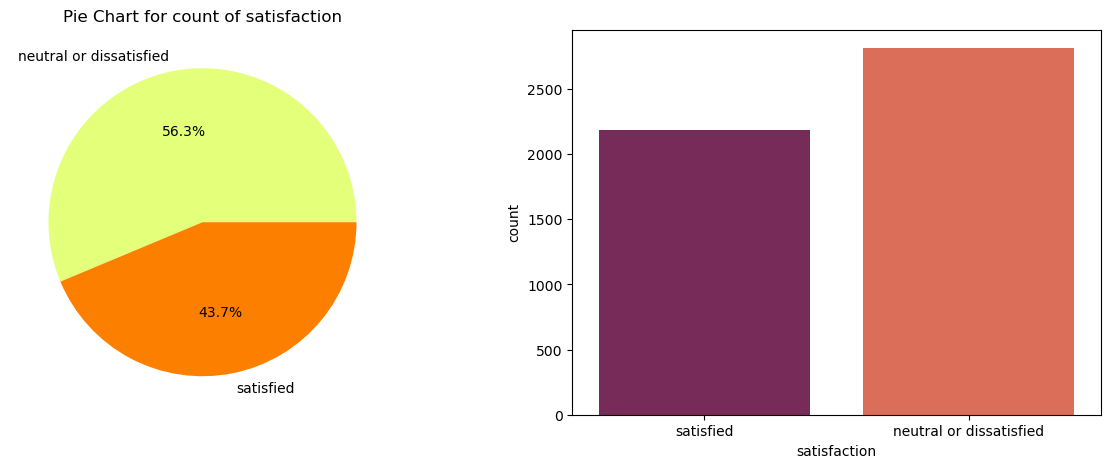

In [25]:
figure, axis = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))
data['satisfaction'].value_counts().plot.pie(ax=axis[0], autopct='%1.1f%%',title="Pie Chart for count of satisfaction", 
                                  legend=False, colormap='Wistia', startangle=0, ylabel='')    

#countplot
sns.countplot(data=data, x='satisfaction', palette="rocket")
plt.show();

In [4]:
#data.columns

In [237]:
## Distribution of each attribute/feature:
## Used seaborn to plot the distribution of each categorical feature.

In [26]:
for column in data.columns:
    print(data[column].value_counts())

PassengerID
1       1
3331    1
3338    1
3337    1
3336    1
       ..
1667    1
1666    1
1665    1
1664    1
5000    1
Name: count, Length: 5000, dtype: int64
CustomerID
19556     1
5914      1
58928     1
15111     1
30669     1
         ..
23499     1
43733     1
16941     1
15965     1
129185    1
Name: count, Length: 5000, dtype: int64
Gender
Female    2500
Male      2500
Name: count, dtype: int64
CustomerType
Loyal Customer       4087
disloyal Customer     913
Name: count, dtype: int64
Age
39    141
25    133
40    127
45    122
46    121
     ... 
77      3
76      2
78      2
75      1
85      1
Name: count, Length: 75, dtype: int64
Type_of_Travel
Business travel    3497
Personal Travel    1503
Name: count, dtype: int64
Class
Business    2428
Eco         2195
Eco Plus     377
Name: count, dtype: int64
Flight_Distance
2475    27
337     27
594     25
237     24
308     22
        ..
1897     1
2385     1
3912     1
2029     1
2449     1
Name: count, Length: 1749, dtype: int64


In [27]:
categorical_variables = ["Gender", "CustomerType", "Type_of_Travel", "Class", "satisfaction"]
numerical_variables = list(set(data.columns) - set(categorical_variables))
print(categorical_variables)
print(numerical_variables)

['Gender', 'CustomerType', 'Type_of_Travel', 'Class', 'satisfaction']
['Departure_Arrival_time_convenient', 'departure_delay_in_minutes', 'Ease_of_Online_booking', 'Food_and_drink', 'Inflight_entertainment', 'CustomerID', 'Cleanliness', 'PassengerID', 'Age', 'Inflight_wifi_service', 'On_board_service', 'Flight_Distance', 'Leg_room_service', 'Online_boarding', 'Seat_comfort', 'Arrival_Delay_in_Minutes']


### Data Visualization

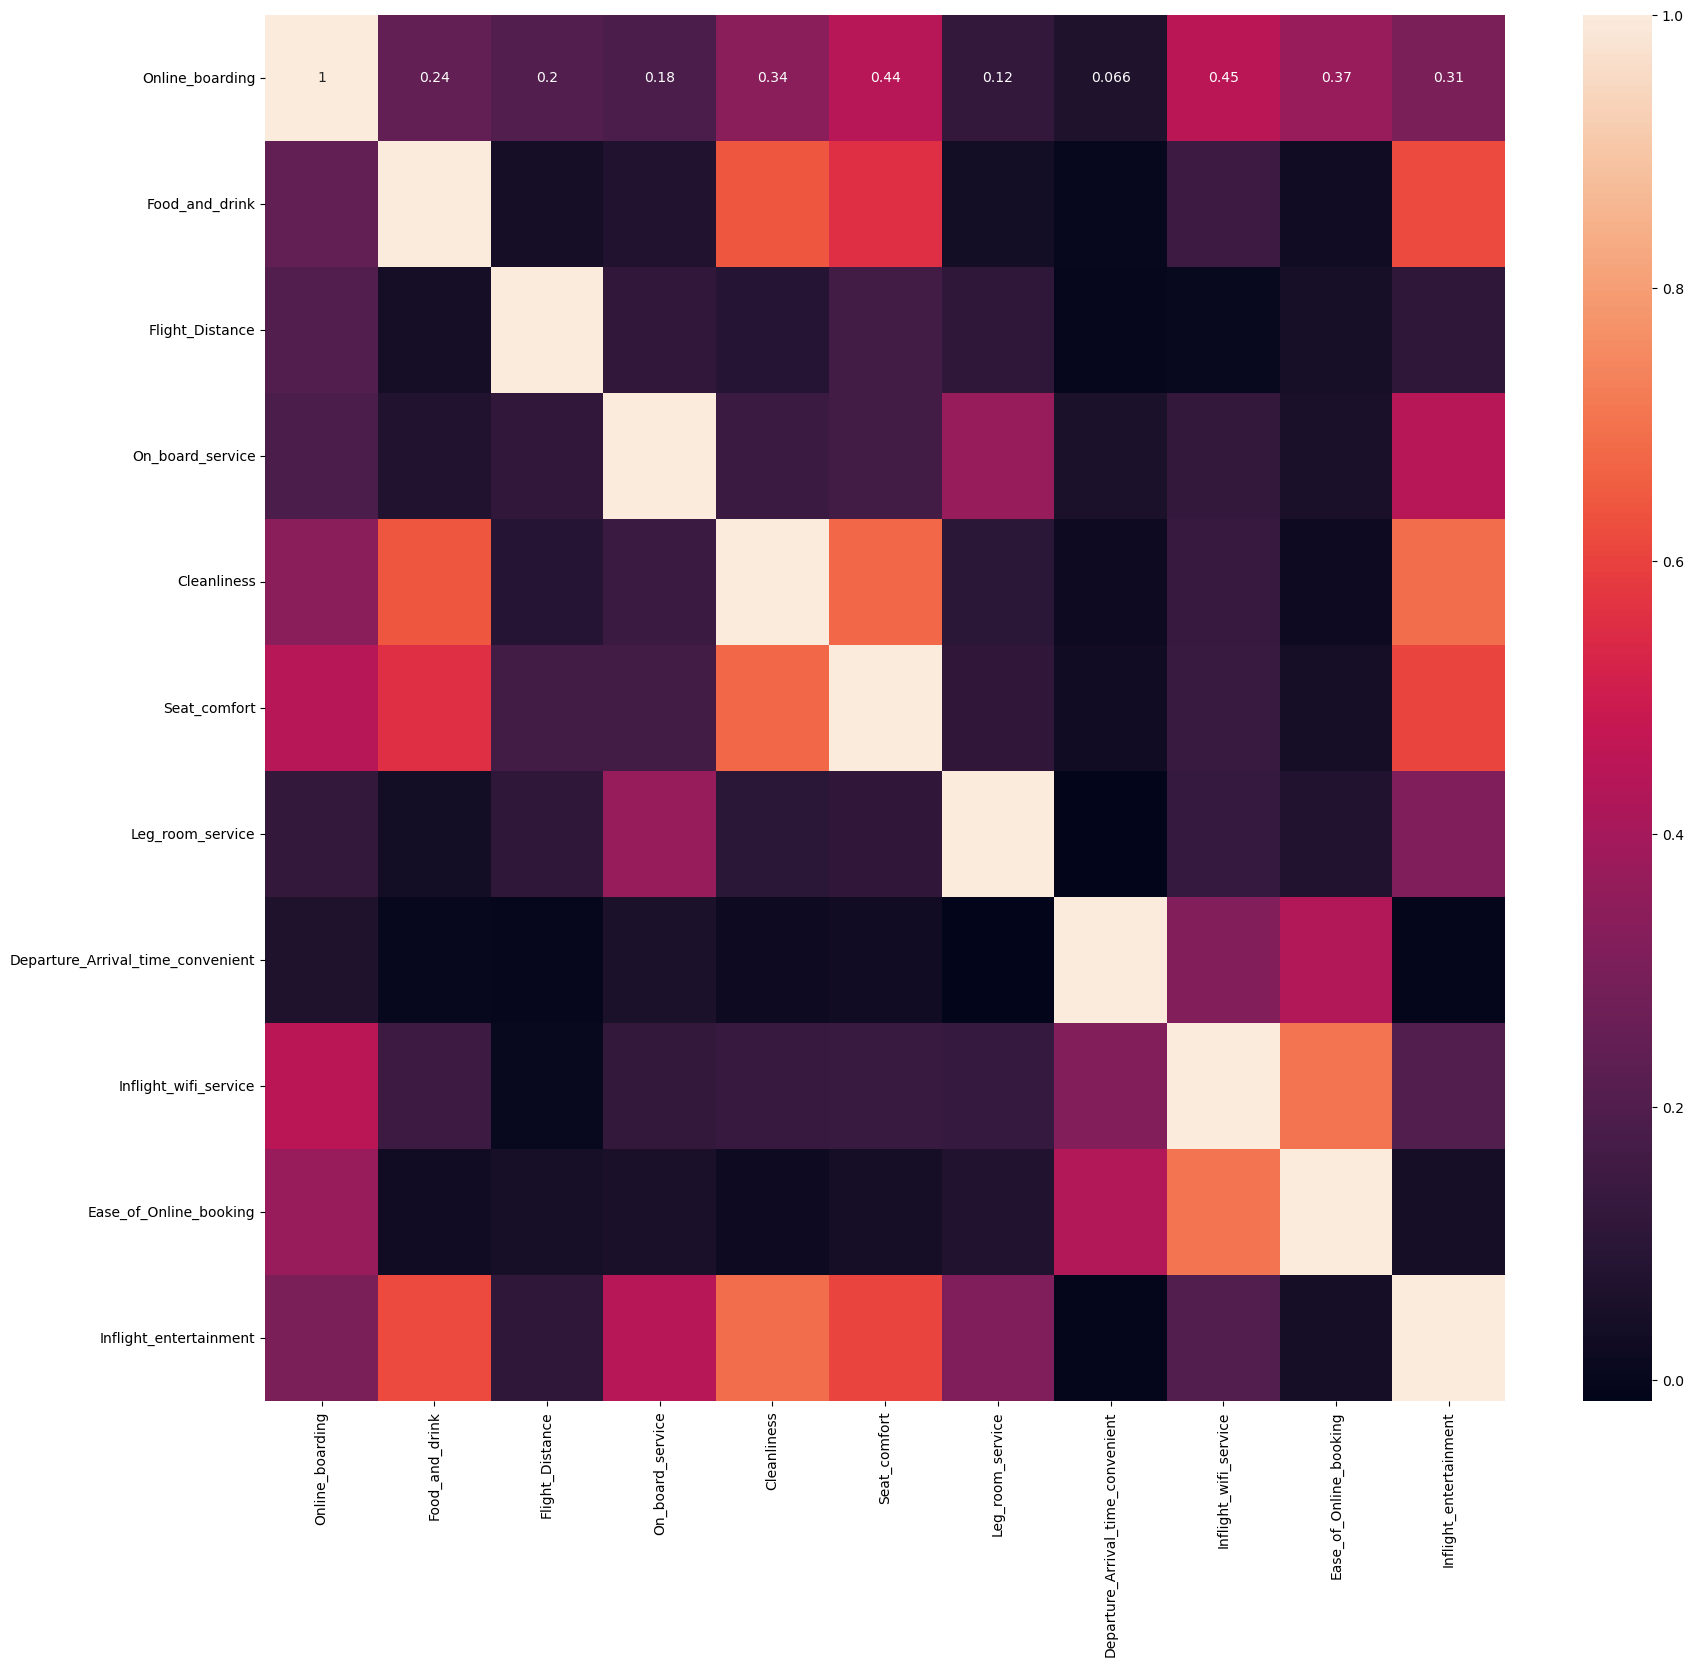

In [28]:
selected_numerical_variables = ['Online_boarding', 'Food_and_drink', 'Flight_Distance','On_board_service', 'Cleanliness', 'Seat_comfort', 'Leg_room_service', 'Departure_Arrival_time_convenient', 'Inflight_wifi_service', 'Ease_of_Online_booking', 'Inflight_entertainment']
correlation_matrix = data[selected_numerical_variables].corr(method='spearman')
plt.subplots(figsize=(20,18))
sns.heatmap(data = correlation_matrix, annot=True)
plt.show()

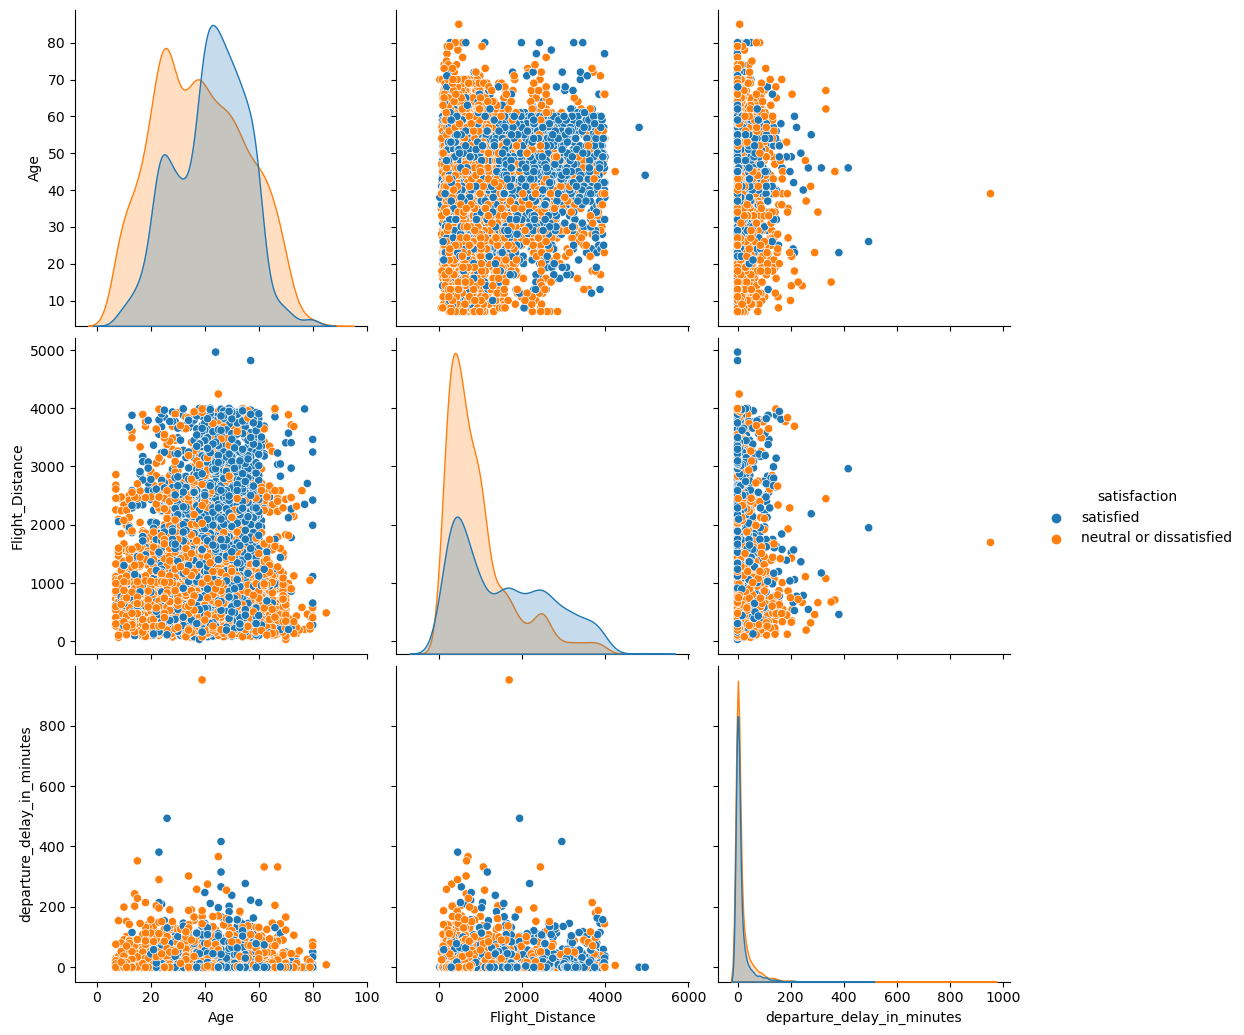

In [29]:
temp_df = data[["Age", "Flight_Distance",  "departure_delay_in_minutes","Arrival_Delay_in_Minutes", "satisfaction"]]

sns.pairplot(data = temp_df, hue='satisfaction', height=3.5, palette='tab10')
plt.show();

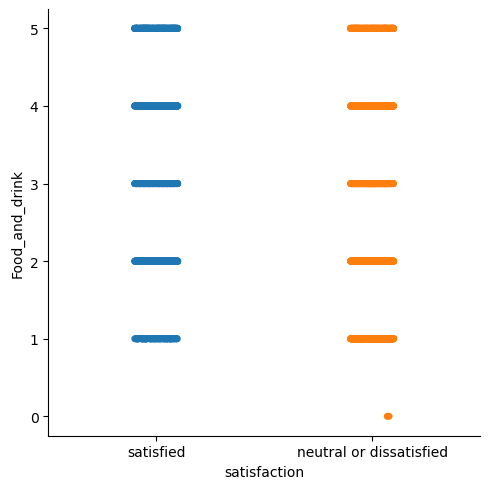

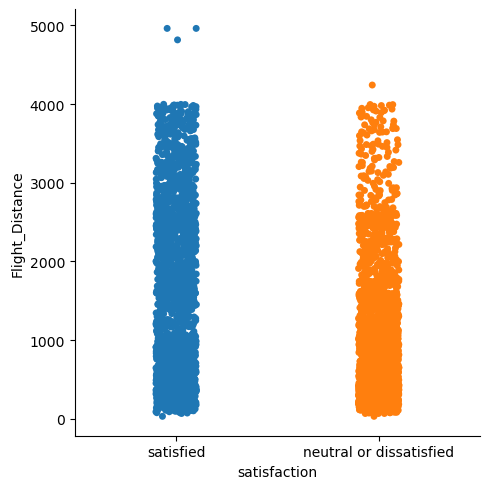

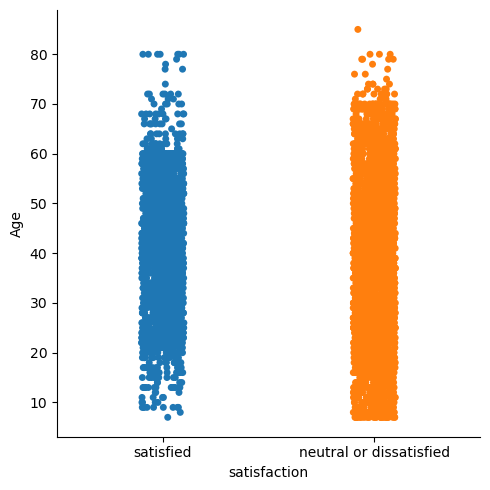

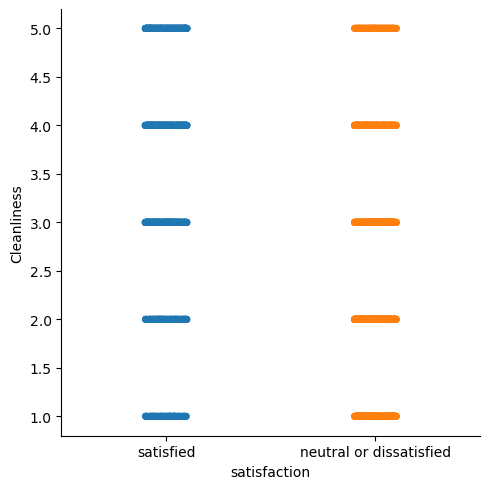

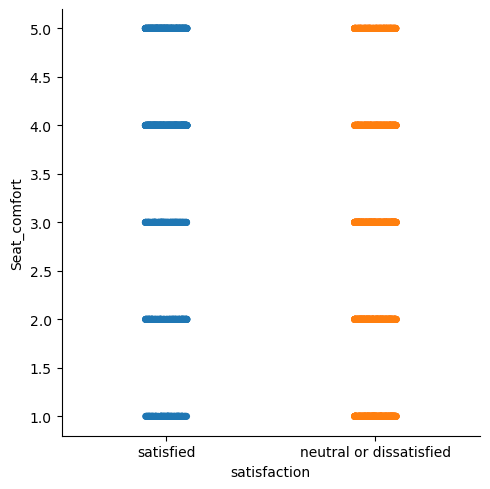

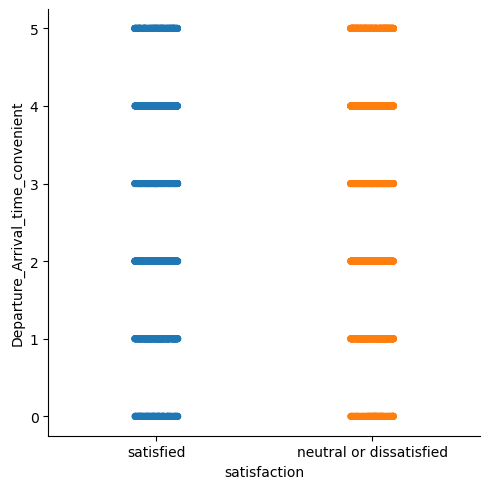

In [30]:
selected_numerical_variables = ['Food_and_drink', 'Flight_Distance', 'Age', 'Cleanliness', 'Seat_comfort', 'Departure_Arrival_time_convenient']
for i in selected_numerical_variables:
    sns.catplot(data=data, y=i, x='satisfaction', palette='tab10')

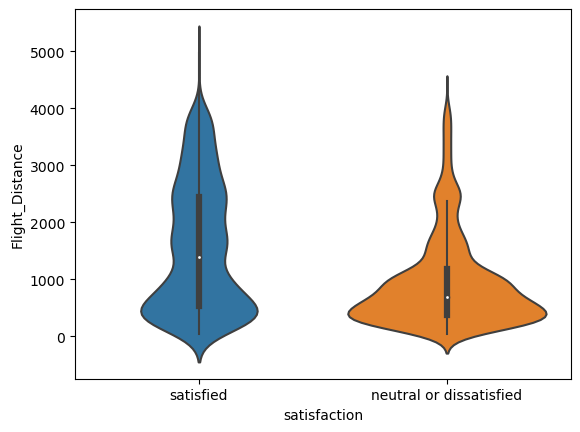

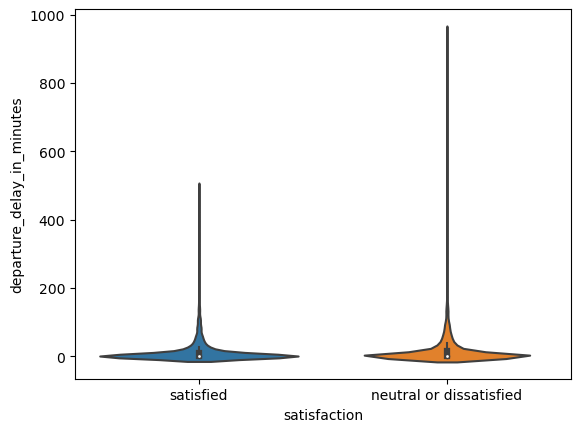

In [35]:
selected_numerical_variables = ['Flight_Distance',"departure_delay_in_minutes"]
for i in selected_numerical_variables:
    sns.violinplot(data=data, x='satisfaction', y=i, palette='tab10')
    plt.show()

In [6]:
#!pip install category_encoders

In [44]:
# categorical_variables.remove("satisfaction")

In [45]:
from category_encoders import OneHotEncoder
df_one_hot = OneHotEncoder(cols=categorical_variables, use_cat_names=True).fit_transform(data)

In [46]:
df_one_hot

,PassengerID,CustomerID,Gender_Female,Gender_Male,CustomerType_Loyal Customer,CustomerType_disloyal Customer,Age,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Eco,...,departure_delay_in_minutes,Inflight_wifi_service,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Cleanliness,satisfaction
0,1,19556,1,0,1,0,52,1,0,1,...,50,5,3,4,3,5,5,5,5,satisfied
1,2,90035,1,0,1,0,36,1,0,0,...,0,1,5,4,5,4,4,4,5,satisfied
2,3,12360,0,1,0,1,20,1,0,1,...,0,2,2,2,2,2,4,1,2,neutral or dissatisfied
3,4,77959,0,1,1,0,44,1,0,0,...,0,0,3,4,4,1,1,1,4,satisfied
4,5,36875,1,0,1,0,49,1,0,1,...,0,2,4,1,2,2,2,2,4,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,52046,0,1,1,0,53,1,0,0,...,0,3,4,5,5,3,3,3,5,satisfied
4996,4997,46605,0,1,0,1,21,1,0,1,...,58,4,5,4,5,5,3,4,5,satisfied
4997,4998,24174,0,1,1,0,59,1,0,1,...,0,4,4,4,4,4,5,2,4,satisfied
4998,4999,105290,0,1,0,1,25,1,0,0,...,86,1,3,2,1,3,5,5,3,neutral or dissatisfied


In [47]:
df_one_hot['satisfaction'] = df_one_hot['satisfaction'].map({ 'neutral or dissatisfied': 1, 'satisfied':0}).astype(int)

In [ ]:
#df_one_hot.columns

In [ ]:
#df_one_hot.head()

In [ ]:
#Scaling Numerical Data

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
transformer = MinMaxScaler()

def scaling(numerical_variables):
    return transformer.fit_transform(df_one_hot[numerical_variables].values.reshape(-1,1))

for i in numerical_variables:
    df_one_hot[i] = scaling(i)

#df_one_hot.head()

### Machine Learning Models :

In [49]:
y = df_one_hot['satisfaction']
X = df_one_hot.drop(['satisfaction'], axis=1)

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [51]:
X_train.head()

,PassengerID,CustomerID,Gender_Female,Gender_Male,CustomerType_Loyal Customer,CustomerType_disloyal Customer,Age,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Eco,...,Arrival_Delay_in_Minutes,departure_delay_in_minutes,Inflight_wifi_service,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Cleanliness
3011,0.602320,0.809317,0,1,1,0,0.679487,1,0,0,...,0.043617,0.046267,0.6,1.0,1.0,0.75,0.6,0.6,0.8,0.75
1780,0.356071,0.331184,1,0,1,0,0.692308,1,0,0,...,0.017021,0.033649,0.8,0.8,0.6,0.50,0.8,0.8,0.8,0.00
3251,0.650330,0.457233,0,1,1,0,0.628205,1,0,0,...,0.000000,0.013670,0.2,1.0,1.0,1.00,0.8,0.8,0.8,0.50
1024,0.204841,0.205759,0,1,1,0,0.435897,1,0,1,...,0.000000,0.004206,0.6,0.6,0.6,0.50,0.6,0.8,0.2,0.50
4158,0.831766,0.244378,0,1,1,0,0.435897,1,0,1,...,0.000000,0.000000,0.8,0.8,0.8,0.75,0.6,0.4,0.6,0.75


In [52]:
y_train.head()

3011    0
1780    1
3251    0
1024    1
4158    0
Name: satisfaction, dtype: int32

In [53]:
Train_columns=X_train.columns  

#### **1. Logistic Regression**

In [54]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

 ************************ LOGISTIC REGRESSION MODEL RESULTS ************************ 
Accuracy score of testing set 0.87 

Precision score of testing set 0.87 

Recall score of testing set 0.87 

F1 score of testing set 0.87 



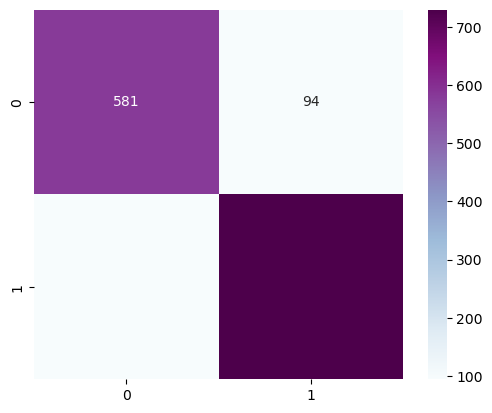

In [55]:
print("\033[1m ************************ LOGISTIC REGRESSION MODEL RESULTS ************************ \033[0m")
print('Accuracy score of testing set', round(accuracy_score(y_test, y_pred_log_reg),2), '\n')
print('Precision score of testing set', round(precision_score(y_test, y_pred_log_reg,average="weighted"),2), '\n')
print('Recall score of testing set', round(recall_score(y_test, y_pred_log_reg,average="weighted"),2), '\n')
print('F1 score of testing set', round(f1_score(y_test, y_pred_log_reg,average="weighted"),2), '\n')
cm_log_reg = confusion_matrix(y_test,y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, square=True, fmt='1', cmap = 'BuPu')
plt.show()

#### 2. Random Forest

In [56]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

 ************************ Random Forest Classifier MODEL RESULTS ************************ 
Accuracy score of testing set 0.94 

Precision score of testing set 0.94 

Recall score of testing set 0.94 

F1 score of testing set 0.94 



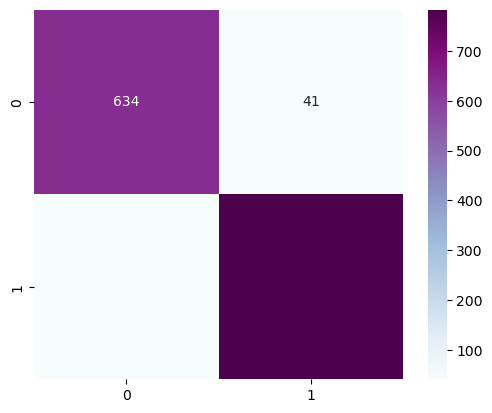

In [57]:
print("\033[1m ************************ Random Forest Classifier MODEL RESULTS ************************ \033[0m")
print('Accuracy score of testing set', round(accuracy_score(y_test, y_pred_rfc),2), '\n')
print('Precision score of testing set', round(precision_score(y_test, y_pred_rfc,average="weighted"),2), '\n')
print('Recall score of testing set', round(recall_score(y_test, y_pred_rfc,average="weighted"),2), '\n')
print('F1 score of testing set', round(f1_score(y_test, y_pred_rfc,average="weighted"),2), '\n')
cm_rfc = confusion_matrix(y_test,y_pred_rfc)
sns.heatmap(cm_rfc, annot=True, square=True, fmt='1', cmap = 'BuPu')
plt.show()

### 3. Decision Tree Classifier

In [58]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dt = dtc.predict(X_test)

 ************************ Decision Tree Classifier MODEL RESULTS ************************ 
Accuracy score of testing set 0.9 

Precision score of testing set 0.9 

Recall score of testing set 0.9 

F1 score of testing set 0.9 



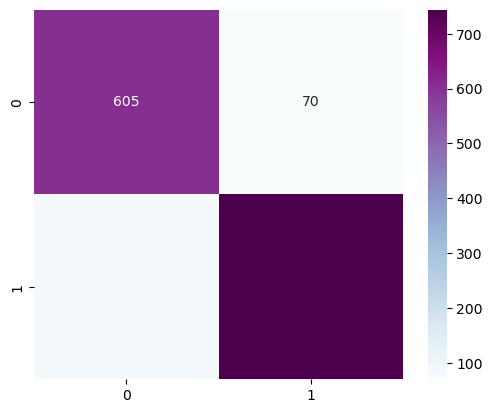

In [59]:
print("\033[1m ************************ Decision Tree Classifier MODEL RESULTS ************************ \033[0m")
print('Accuracy score of testing set', round(accuracy_score(y_test, y_pred_dt),2), '\n')
print('Precision score of testing set', round(precision_score(y_test, y_pred_dt,average="weighted"),2), '\n')
print('Recall score of testing set', round(recall_score(y_test, y_pred_dt,average="weighted"),2), '\n')
print('F1 score of testing set', round(f1_score(y_test, y_pred_dt,average="weighted"),2), '\n')
cm_dtc = confusion_matrix(y_test,y_pred_dt)
sns.heatmap(cm_dtc, annot=True, square=True, fmt='1', cmap = 'BuPu')
plt.show()

### 4. KNN Classifier

In [60]:


# Ensure X_train and X_test are numpy arrays and are contiguous in memory.
if not isinstance(X_train, np.ndarray):
    X_train = np.ascontiguousarray(X_train.values) if hasattr(X_train, 'values') else np.ascontiguousarray(X_train)

if not isinstance(X_test, np.ndarray):
    X_test = np.ascontiguousarray(X_test.values) if hasattr(X_test, 'values') else np.ascontiguousarray(X_test)

# Check if there are any missing values that need handling.
if np.isnan(X_train).any() or np.isnan(X_test).any():
    raise ValueError("Input contains NaN values. Handle missing values before fitting the model.")

# Now, try fitting the model again
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


 ************************ K Neighbors Classifier MODEL RESULTS ************************ 
Accuracy score of testing set 0.9 

Precision score of testing set 0.9 

Recall score of testing set 0.9 

F1 score of testing set 0.9 



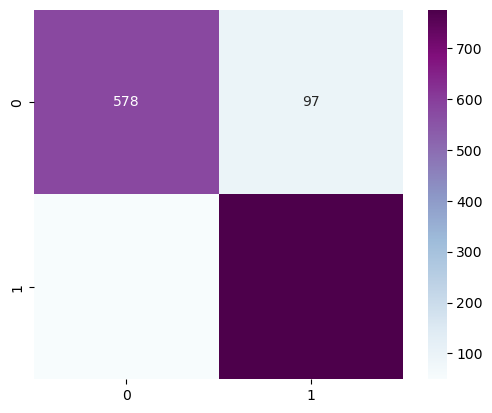

In [61]:
print("\033[1m ************************ K Neighbors Classifier MODEL RESULTS ************************ \033[0m")
print('Accuracy score of testing set', round(accuracy_score(y_test, y_pred_knn),2), '\n')
print('Precision score of testing set', round(precision_score(y_test, y_pred_knn,average="weighted"),2), '\n')
print('Recall score of testing set', round(recall_score(y_test, y_pred_knn,average="weighted"),2), '\n')
print('F1 score of testing set', round(f1_score(y_test, y_pred_dt,average="weighted"),2), '\n')
cm_knn = confusion_matrix(y_test,y_pred_knn)
sns.heatmap(cm_knn, annot=True, square=True, fmt='1', cmap = 'BuPu')
plt.show()

In [62]:
# Model Comparision

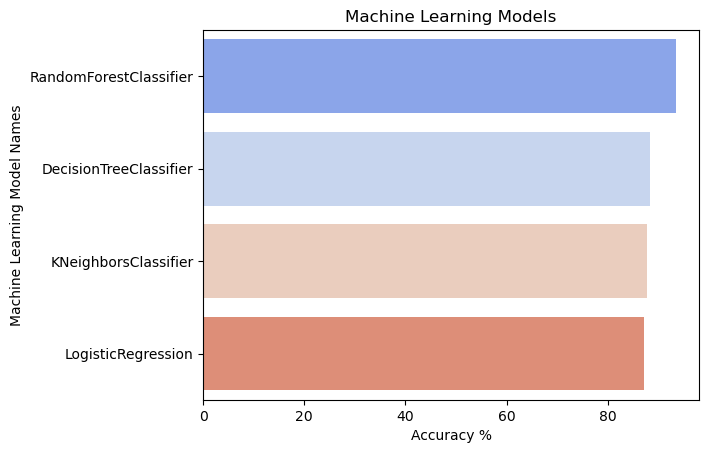

In [63]:
models = [log_reg, rfc, dtc, knn]

result_accuracy = []
results_accuracy = pd.DataFrame(columns=["Models", "Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accuracy = cross_val_score(model, X_test, y_test, cv=3, scoring="accuracy", n_jobs=-1).mean()
    result_accuracy = pd.DataFrame([[names, accuracy*100]], columns=["Models", "Accuracy"])
    results_accuracy = results_accuracy._append(result_accuracy)
    
sns.barplot(x='Accuracy', y='Models', data=results_accuracy.sort_values(by='Accuracy',ascending=False), palette="coolwarm")
plt.xlabel('Accuracy %')
plt.ylabel("Machine Learning Model Names")
plt.title("Machine Learning Models", loc="center")
plt.show();

In [66]:
results_accuracy.sort_values(by='Accuracy',ascending=False)

,Models,Accuracy
0,RandomForestClassifier,93.400000
0,DecisionTreeClassifier,88.333333
0,KNeighborsClassifier,87.666667
0,LogisticRegression,87.066667


### Feature Engineering

In [67]:
data['Adult'] = data['Age']
data.loc[list(data[data['Age'] < 18].index), ['Adult']] = 0
data.loc[list(data[data['Age'] >= 18].index), ['Adult']] = 1

In [68]:
data['Time'] = data['Flight_Distance'] / 20 + data['departure_delay_in_minutes'] 
data['Adult'].value_counts()

Adult
1    4612
0     388
Name: count, dtype: int64

In [69]:
data['Time'].value_counts()

Time
123.75    18
16.85     16
11.85     16
15.40     14
50.45     13
          ..
81.45      1
124.75     1
293.30     1
66.95      1
122.90     1
Name: count, Length: 2440, dtype: int64

In [70]:
data['Comfort'] = data['Seat_comfort'] * data['Cleanliness'] * data['Food_and_drink']
data['Comfort'].value_counts()

Comfort
64     685
125    597
27     502
8      499
1      384
60     215
100    205
80     187
48     181
75     140
36     130
24     127
40     118
12     101
16      99
45      92
32      92
50      81
30      71
4       65
9       64
18      64
20      63
6       57
2       38
25      36
3       32
15      32
10      26
5       15
0        2
Name: count, dtype: int64

In [71]:
data['Comfort+'] = data['Seat_comfort'] + data['Cleanliness'] + data['Food_and_drink']
data['Comfort+'].value_counts()

Comfort+
12    981
9     746
15    597
6     551
11    427
3     384
13    327
10    321
14    205
8     192
7     161
5      70
4      38
Name: count, dtype: int64

In [72]:
#### Feature Importance 

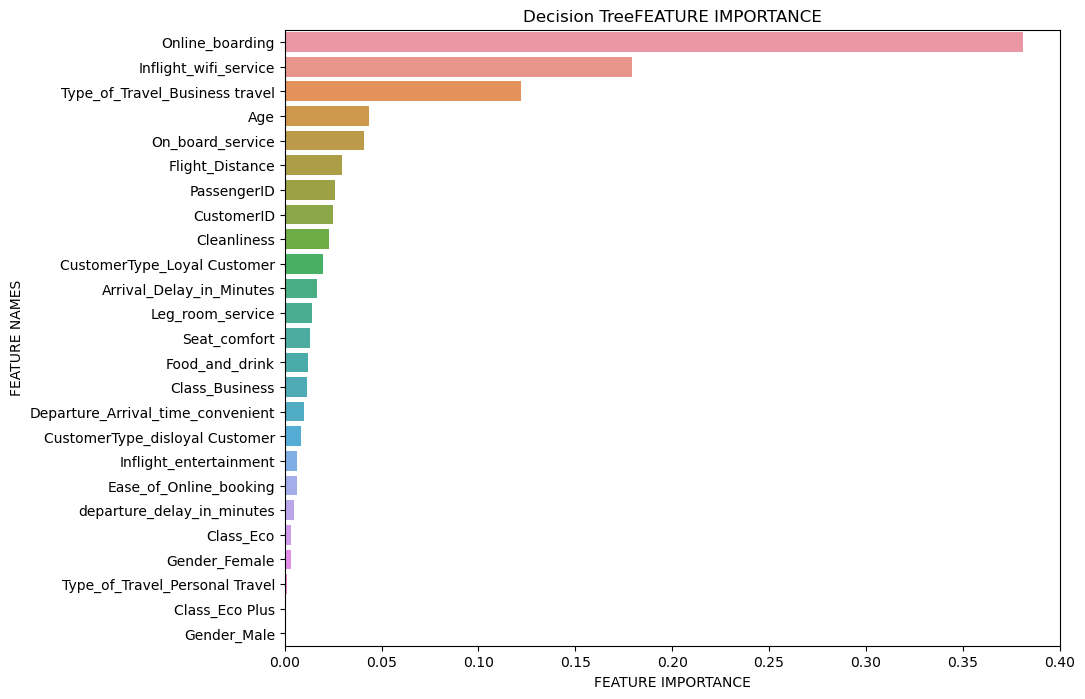

In [73]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(dtc.feature_importances_, Train_columns, 'Decision Tree')

In [74]:
Train_columns

Index(['PassengerID', 'CustomerID', 'Gender_Female', 'Gender_Male',
       'CustomerType_Loyal Customer', 'CustomerType_disloyal Customer', 'Age',
       'Type_of_Travel_Business travel', 'Type_of_Travel_Personal Travel',
       'Class_Eco', 'Class_Business', 'Class_Eco Plus', 'Flight_Distance',
       'Departure_Arrival_time_convenient', 'Ease_of_Online_booking',
       'Arrival_Delay_in_Minutes', 'departure_delay_in_minutes',
       'Inflight_wifi_service', 'Food_and_drink', 'Online_boarding',
       'Seat_comfort', 'Inflight_entertainment', 'On_board_service',
       'Leg_room_service', 'Cleanliness'],
      dtype='object')

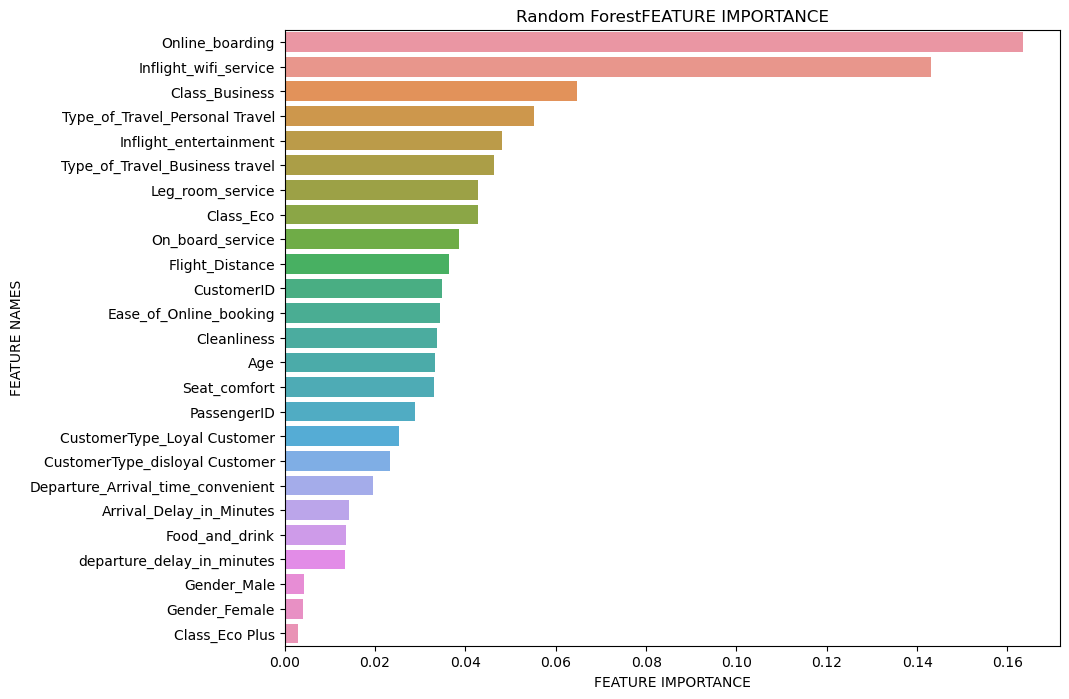

In [75]:
plot_feature_importance(rfc.feature_importances_, Train_columns, 'Random Forest')

In [76]:


newData = df_one_hot.drop(['Gender_Female', 'Gender_Male', "Class_Eco Plus",'CustomerType_Loyal Customer'], axis = 1)
X_new, y_new = newData.drop(["satisfaction"], axis = 1), newData['satisfaction']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.1, random_state = 42)
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
y_pred_rfc = model_rf.predict(X_test)

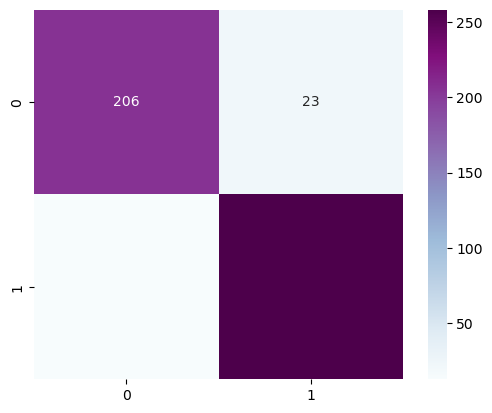

In [77]:
cm_rfc = confusion_matrix(y_test,y_pred_rfc)
sns.heatmap(cm_rfc, annot=True, square=True, fmt='1', cmap = 'BuPu')
plt.show()

In [361]:
#Hyperparameter Optimization 

rfc_parameters = {
    'n_estimators': [100, 200, 300], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9]
}

In [362]:
rfc_cv = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc_cv, rfc_parameters, cv=3).fit(X_train, y_train)
print("Best parameters of Random Forest Classifier:", str(rfc_grid.best_params_))

Best parameters of Random Forest Classifier: {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 100}


In [363]:
rfc_grid.best_estimator_

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9)

In [ ]:
# Tuning

In [352]:
rfc_tuned = RandomForestClassifier(max_depth=9, max_features='sqrt', max_leaf_nodes=9, n_estimators=300)
rfc_tuned.fit(X_train,y_train)
y_pred_rfc_tuned = rfc_tuned.predict(X_test)

 ******** Tuned Random Forest Classifier Training MODEL RESULTS ******** 
Accuracy score of testing set 0.9 

Precision score of testing set 0.89 

Recall score of testing set 0.89 

F1 score of testing set 0.89 

 ******** Tuned Random Forest Classifier Testing MODEL RESULTS ******** 
Accuracy score of testing set 0.85 

Precision score of testing set 0.85 

Recall score of testing set 0.85 

F1 score of testing set 0.84 



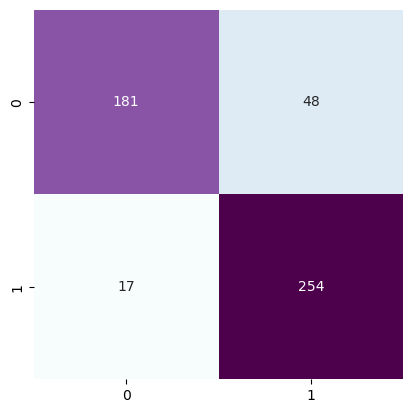

In [353]:
print("\033[1m ******** Tuned Random Forest Classifier Training MODEL RESULTS ******** \033[0m")
print('Accuracy score of testing set', round(cross_val_score(rfc_tuned, X_train, y_train, cv=3, scoring= 'accuracy').mean(),2), '\n')
print('Precision score of testing set', round(cross_val_score(rfc_tuned, X_train, y_train, cv=3, scoring= 'precision_weighted').mean(),2), '\n')
print('Recall score of testing set', round(cross_val_score(rfc_tuned, X_train, y_train, cv=3, scoring= 'recall_weighted').mean(),2), '\n')
print('F1 score of testing set', round(cross_val_score(rfc_tuned, X_train, y_train, cv=3, scoring= 'f1_weighted').mean(),2), '\n')

print("\033[1m ******** Tuned Random Forest Classifier Testing MODEL RESULTS ******** \033[0m")
print('Accuracy score of testing set', round(cross_val_score(rfc_tuned, X_test, y_test, cv=3, scoring= 'accuracy').mean(),2), '\n')
print('Precision score of testing set', round(cross_val_score(rfc_tuned, X_test, y_test, cv=3, scoring= 'precision_weighted').mean(),2), '\n')
print('Recall score of testing set', round(cross_val_score(rfc_tuned, X_test, y_test, cv=3, scoring= 'recall_weighted').mean(),2), '\n')
print('F1 score of testing set', round(cross_val_score(rfc_tuned, X_test, y_test, cv=3, scoring= 'f1_weighted').mean(),2), '\n')

cm_rfc = confusion_matrix(y_test,y_pred_rfc_tuned)
sns.heatmap(cm_rfc, annot=True, square=True, fmt='1', cmap = 'BuPu', cbar=False)
plt.show()

Best parameters of Decision Tree Classifier: {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
 ******** Tuned Decision Tree Classifier MODEL RESULTS ******** 
Accuracy score: 0.91
Precision score: 0.91
Recall score: 0.91
F1 score: 0.91


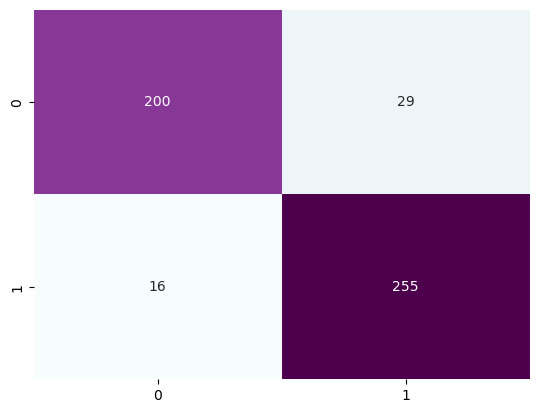

In [354]:

dt_parameters = {
    'max_depth': [3, 6, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


dtc_cv = DecisionTreeClassifier(random_state=42)
dtc_grid = GridSearchCV(dtc_cv, dt_parameters, cv=3).fit(X_train, y_train)
print("Best parameters of Decision Tree Classifier:", dtc_grid.best_params_)


dtc_tuned = DecisionTreeClassifier(**dtc_grid.best_params_)
dtc_tuned.fit(X_train, y_train)
y_pred_dtc_tuned = dtc_tuned.predict(X_test)


print("\033[1m ******** Tuned Decision Tree Classifier MODEL RESULTS ******** \033[0m")
print('Accuracy score:', round(accuracy_score(y_test, y_pred_dtc_tuned), 2))
print('Precision score:', round(precision_score(y_test, y_pred_dtc_tuned, average='weighted'), 2))
print('Recall score:', round(recall_score(y_test, y_pred_dtc_tuned, average='weighted'), 2))
print('F1 score:', round(f1_score(y_test, y_pred_dtc_tuned, average='weighted'), 2))


cm_dtc = confusion_matrix(y_test, y_pred_dtc_tuned)
sns.heatmap(cm_dtc, annot=True, fmt='d', cmap='BuPu', cbar=False)
plt.show()


Best parameters of Logistic Regression: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
 ******** Tuned Logistic Regression MODEL RESULTS ******** 
Accuracy score: 0.87
Precision score: 0.87
Recall score: 0.87
F1 score: 0.87


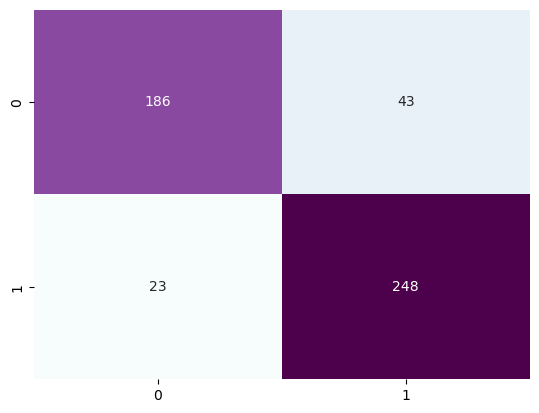

In [355]:

lr_parameters = {
    'C': [0.1, 1, 10],  
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}


lr_cv = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr_cv, lr_parameters, cv=3).fit(X_train, y_train)
print("Best parameters of Logistic Regression:", lr_grid.best_params_)

# Tuning
lr_tuned = LogisticRegression(**lr_grid.best_params_)
lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)


print("\033[1m ******** Tuned Logistic Regression MODEL RESULTS ******** \033[0m")
print('Accuracy score:', round(accuracy_score(y_test, y_pred_lr_tuned), 2))
print('Precision score:', round(precision_score(y_test, y_pred_lr_tuned, average='weighted'), 2))
print('Recall score:', round(recall_score(y_test, y_pred_lr_tuned, average='weighted'), 2))
print('F1 score:', round(f1_score(y_test, y_pred_lr_tuned, average='weighted'), 2))


cm_lr = confusion_matrix(y_test, y_pred_lr_tuned)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='BuPu', cbar=False)
plt.show()

### Conclusion:
The feature importance analysis from the model indicates that passengers prioritize efficient and convenient travel experiences, with 'Online_boarding' and 'Inflight_wifi_service' ranking as the top influencers of satisfaction. This suggests that investments in technology to streamline boarding processes and enhance onboard connectivity could significantly improve passenger satisfaction. Although comforts associated with business class and inflight entertainment are also valued, they are secondary to the efficiency and connectivity features. Airlines should therefore focus on enhancing digital and technological services while maintaining high standards in comfort and entertainment to meet overall passenger expectations and remain competitive in the industry.